In [1]:
%%HTML
<style>.container { width:100% }
</style>

# Neural Network Using TensorFlow

In [2]:
import gzip
import pickle
import random
import numpy             as np
import matplotlib.pyplot as plt
import tensorflow        as tf

The following magic command is necessary to prevent the Python kernel to die because of linkage problems.

In [3]:
%env KMP_DUPLICATE_LIB_OK=TRUE

env: KMP_DUPLICATE_LIB_OK=TRUE


The function $\texttt{vectorized_result}(d)$ converts the digit $d \in \{0,\cdots,9\}$ and returns a NumPy vector $\mathbf{x}$ of shape $(10, 1)$ such that
$$
\mathbf{x}[i] = 
\left\{
  \begin{array}{ll}
     1 & \mbox{if $i = j$;} \\
     0 & \mbox{otherwise.}
  \end{array}  
\right.
$$
This function is used to convert a digit $d$ into the expected output of a neural network that has an output unit for every digit.

In [4]:
def vectorized_result(d):
    e    = np.zeros((10, ), dtype=np.float32)
    e[d] = 1.0
    return e

The data that we are using is stored as a <a href="https://docs.python.org/3/library/gzip.html">gzipped</a>, 
<a href="https://docs.python.org/3/library/pickle.html">pickled</a> file.  

The function $\texttt{load_data}()$ returns a pair of the form
$$ (\texttt{training_data}, \texttt{test_data}) $$
where 
- $\texttt{training_data}$ is a list containing $50,000$ pairs $(\textbf{x}, \textbf{y})$ s.t. $\textbf{x}$ is a 
  784-dimensional `numpy.ndarray` containing the input image and $\textbf{y}$ is a 10-dimensional `numpy.ndarray`   
  corresponding to the correct digit for x.
- $\texttt{test_data}$ is a list containing $10,000$ pairs $(\textbf{x}, \textbf{y})$.  In each case, 
  $\textbf{x}$ is a 784-dimensional `numpy.ndarry` containing the input image
  and $\textbf{y}$ is a 10-dimensional `numpy.ndarray` corresponding to the correct digit for $\textbf{x}$.
  
We do not use the validation data that are provided in the file `mnist.pkl.gz`.

In [5]:
def load_data():
    with gzip.open('mnist.pkl.gz', 'rb') as f:
        train, validate, test = pickle.load(f, encoding="latin1")
    X_train = np.array([np.reshape(x, (784, )) for x in train[0]])
    X_test  = np.array([np.reshape(x, (784, )) for x in test [0]])
    Y_train = np.array([vectorized_result(y) for y in train[1]])
    Y_test  = np.array([vectorized_result(y) for y in test [1]])
    return X_train.T, X_test.T, Y_train.T, Y_test.T

In [6]:
X_train, X_test, Y_train, Y_test = load_data()
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((784, 50000), (784, 10000), (10, 50000), (10, 10000))

The function $\texttt{show_digit}(\texttt{row}, \texttt{columns}, \texttt{offset})$ 
shows $\texttt{row} \cdot \texttt{columns}$ images of the training data.  The first image shown is the image at index $\texttt{offset}$.

In [7]:
def show_digits(rows, columns, offset=0):
    f, axarr = plt.subplots(rows, columns)
    for r in range(rows):
        for c in range(columns):
            i     = r * columns + c + offset
            image = 1 - X_train[:,i]
            image = np.reshape(image, (28, 28))
            axarr[r, c].imshow(image, cmap="gray")
            axarr[r, c].axis('off')
    plt.savefig("digits.pdf")    
    plt.show()

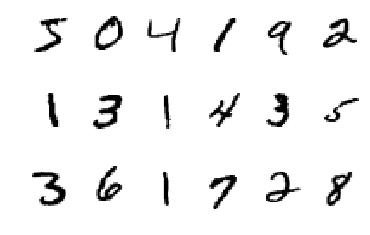

In [8]:
show_digits(3, 6)

We create placeholders to use for the data.  Below, `None` stands for the yet unknown number of training examples.

In [9]:
X = tf.placeholder(tf.float32, [784, None]) # mnist data images of shape (28*28=784, ?)
Y = tf.placeholder(tf.float32, [ 10, None]) # 0-9 digits recognition => 10 classes

Our goal is to find the <em style="color:blue;">weight matrices</em> and <em style="color:blue;">biases</em> for a neural net that is 
able to recognize the digits shown in these images.  We initialize these weight matrices randomly. The function $\texttt{rndMatrix}(\texttt{rows}, \texttt{cols})$ returns a matrix of shape $(\texttt{rows}, \texttt{cols})$ that is filled with random numbers that have a Gaussian distribution with mean $0$ and variance $\displaystyle\frac{1}{\texttt{rows}}$.

In [10]:
def rndMatrix(rows, cols):
    return tf.truncated_normal((rows, cols), 0.0, 1 / np.sqrt(cols))

Specify the <em style="color:blue;">topology</em> of the neural network.

In [11]:
inputSize  = 28 * 28
hiddenSize = 60
outputSize = 10

In [12]:
biasesH  = tf.Variable(tf.zeros((hiddenSize, 1)        )) # biases hidden layer  
biasesO  = tf.Variable(tf.zeros((outputSize, 1)        )) # biases output layer 
weightsH = tf.Variable(rndMatrix(hiddenSize, inputSize )) # weights hidden layer
weightsO = tf.Variable(rndMatrix(outputSize, hiddenSize)) # weights output layer

In [13]:
AH     = tf.sigmoid(weightsH @  X + biasesH) # activation hidden layer
Y_pred = tf.sigmoid(weightsO @ AH + biasesO) # activation output layer

We use the mean squared error as our loss function.

In [14]:
cost = tf.losses.mean_squared_error(Y, Y_pred)

W0325 13:48:35.056923 4573257152 deprecation.py:323] From /Users/karlstroetmann/anaconda3/envs/ds/lib/python3.7/site-packages/tensorflow/python/ops/losses/losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Set some variables and hyperparameters.

In [15]:
α         =  15
epochs    =  60
mbs       = 100             # mini batch size
n_test    = X_test.shape[1]
n         = X_train.shape[1]
n_batches = int(n / mbs)

We use <em style="color:blue;">gradient descent</em> to minimize this cost function.

In [16]:
optimizer = tf.train.GradientDescentOptimizer(α).minimize(cost)

The function $\texttt{next_batch}(s)$ returns the next batch of the given size.  It returns a pair of the form $(X, Y)$ where $X$ is a matrix of shape
$(784, s)$ and $Y$ is a matrix of shape $(10, s)$.

In [17]:
def next_batch(size):
    global count
    X_batch  = X_train[:, count:count+size]
    Y_batch  = Y_train[:, count:count+size]
    count   += size
    return X_batch, Y_batch

In [18]:
%%time
tf.set_random_seed(42)
init = tf.global_variables_initializer()
with tf.Session() as tfs:
    tfs.run(init)
    for j in range(epochs):
        count    = 0
        avg_cost = 0.0
        for i in range(n_batches):
            X_batch, Y_batch = next_batch(mbs)
            _, c = tfs.run([optimizer, cost], {X: X_batch, Y: Y_batch})
            avg_cost += c / n_batches
        correct = tfs.run(tf.equal(tf.argmax(Y_pred, 0), tf.argmax(Y, 0)), {X: X_test, Y: Y_test})
        print('Epoch: %2d, accuracy: %.4f, cost %.5f' % (j, np.sum(correct) / len(correct), avg_cost))
    print("Optimization Finished!")

Epoch:  0, accuracy: 0.9135, cost 0.03208
Epoch:  1, accuracy: 0.9280, cost 0.01460
Epoch:  2, accuracy: 0.9373, cost 0.01205
Epoch:  3, accuracy: 0.9427, cost 0.01055
Epoch:  4, accuracy: 0.9457, cost 0.00951
Epoch:  5, accuracy: 0.9491, cost 0.00874
Epoch:  6, accuracy: 0.9519, cost 0.00811
Epoch:  7, accuracy: 0.9543, cost 0.00759
Epoch:  8, accuracy: 0.9558, cost 0.00713
Epoch:  9, accuracy: 0.9575, cost 0.00673
Epoch: 10, accuracy: 0.9591, cost 0.00638
Epoch: 11, accuracy: 0.9605, cost 0.00607
Epoch: 12, accuracy: 0.9616, cost 0.00580
Epoch: 13, accuracy: 0.9623, cost 0.00555
Epoch: 14, accuracy: 0.9632, cost 0.00533
Epoch: 15, accuracy: 0.9637, cost 0.00512
Epoch: 16, accuracy: 0.9641, cost 0.00494
Epoch: 17, accuracy: 0.9653, cost 0.00477
Epoch: 18, accuracy: 0.9660, cost 0.00461
Epoch: 19, accuracy: 0.9662, cost 0.00447
Epoch: 20, accuracy: 0.9669, cost 0.00433
Epoch: 21, accuracy: 0.9670, cost 0.00420
Epoch: 22, accuracy: 0.9673, cost 0.00408
Epoch: 23, accuracy: 0.9675, cost 